### 모듈 install & import

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

### 최종 데이터 불러오기
* movie_final_분류 : 전국 관객수 80만명 이상, 전국 스크린수 50개 이상   
* movie_final_all : 전국 관객수 1000명 이상, 전국 스크린수 50개 이상

In [2]:
movie_final_분류 = pd.read_csv('../3_merge_top300/movie_final_cls.csv',encoding='utf-8')
movie_final_all = pd.read_csv('../3_merge_top300/movie_final_all.csv',encoding='utf-8')

## 1. movie_final_분류 분석

### 스케일링
전국 스크린수와 총 관객수를 스케일링: RobustScaler() 사용

In [3]:
# 객체생성
robust_scaler = RobustScaler()

# *** '전국 스크린수'와 '총 관객수' 컬럼을 스케일링 ***
A_n = robust_scaler.fit_transform(movie_final_분류['전국 스크린수'].values.reshape(-1,1))
movie_final_분류.insert(0, '전국 스크린수_scaled', A_n)
movie_final_분류.drop(['전국 스크린수'], axis=1, inplace=True)

A_n1 = robust_scaler.fit_transform(movie_final_분류['총 관객수'].values.reshape(-1,1))
movie_final_분류.insert(0, '총 관객수_scaled', A_n1)
movie_final_분류.drop(['총 관객수'], axis=1, inplace=True)

# 변경이 잘 되었는지 확인
movie_final_분류.columns

Index(['총 관객수_scaled', '전국 스크린수_scaled', 'Unnamed: 0', '순번', '영화명', '감독',
       '배급사', '개봉일', '영화형태', '국적', '전국 매출액', '전국 관객수', '서울 매출액', '서울 관객수',
       '장르', '등급', '영화구분', '연도', '월', '계절', '코로나', '출연', '평점', '감독_흥행',
       '배급사_흥행', '주연배우_흥행'],
      dtype='object')

### 라벨링
명목형 자료들을 라벨링: LabelEncoder() 사용

In [5]:
# input 데이터 라벨링

le_form = LabelEncoder()
le_nation = LabelEncoder()
le_genre = LabelEncoder()
le_rating = LabelEncoder()
le_class = LabelEncoder()
le_season = LabelEncoder()
le_year = LabelEncoder()

movie_labels = movie_final_분류.copy()
movie_labels['영화형태'] = le_form.fit_transform(movie_final_분류['영화형태'])
movie_labels['국적'] = le_nation.fit_transform(movie_final_분류['국적'])
movie_labels['장르'] = le_genre.fit_transform(movie_final_분류['장르'])
movie_labels['등급'] = le_rating.fit_transform(movie_final_분류['등급'])
movie_labels['영화구분'] = le_class.fit_transform(movie_final_분류['영화구분'])
movie_labels['계절'] = le_season.fit_transform(movie_final_분류['계절'])
movie_labels['연도'] = le_year.fit_transform(movie_final_분류['연도'])
movie_labels.drop(['Unnamed: 0'],axis=1,inplace=True)
movie_labels.columns


Index(['총 관객수_scaled', '전국 스크린수_scaled', '순번', '영화명', '감독', '배급사', '개봉일',
       '영화형태', '국적', '전국 매출액', '전국 관객수', '서울 매출액', '서울 관객수', '장르', '등급',
       '영화구분', '연도', '월', '계절', '코로나', '출연', '평점', '감독_흥행', '배급사_흥행',
       '주연배우_흥행'],
      dtype='object')

In [6]:
# target 데이터 라벨링
# 전국 관객수 기준, [100만미만/100만/150만/300만/500만]으로 나누어 라벨링

movie_labels['분류클래스'] = np.where((movie_labels['전국 관객수'].values<1000000), 0, 
                                 np.where((movie_labels['전국 관객수'].values>=1000000) & (movie_labels['전국 관객수'].values<1500000), 1,
                                          np.where((movie_labels['전국 관객수'].values>=1500000) & (movie_labels['전국 관객수'].values<3000000), 2,
                                                   np.where((movie_labels['전국 관객수'].values>=3000000) & (movie_labels['전국 관객수'].values<5000000), 3, 4))))

classes = sorted(movie_labels['분류클래스'].unique())
print(classes)
for i in classes:
    print(i, len(movie_labels[movie_labels['분류클래스']==i]))

[0, 1, 2, 3, 4]
0 100
1 149
2 249
3 109
4 101


### 변수 정리
사용하는 컬럼만 독립변수와 종속변수에 할당

In [7]:
독립 = movie_labels[['장르', '등급', '감독_흥행','총 관객수_scaled',
               '배급사_흥행','주연배우_흥행','계절', '전국 스크린수_scaled','연도','코로나']].copy()

종속 = movie_labels[['분류클래스']].copy()

display(독립.info())
print()
display(종속.describe().round())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   장르              708 non-null    int64  
 1   등급              708 non-null    int64  
 2   감독_흥행           708 non-null    int64  
 3   총 관객수_scaled    708 non-null    float64
 4   배급사_흥행          708 non-null    int64  
 5   주연배우_흥행         708 non-null    int64  
 6   계절              708 non-null    int64  
 7   전국 스크린수_scaled  708 non-null    float64
 8   연도              708 non-null    int64  
 9   코로나             708 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 55.4 KB


None

,분류클래스
count,708.0
mean,2.0
std,1.0
min,0.0
25%,1.0
50%,2.0
75%,3.0
max,4.0


### train, validation, test용 데이터 나누기

In [8]:
# 1. train 데이터(80%)와 test 데이터(20%)로 나누기
train_input, test_input, train_target, test_target = train_test_split(독립, 종속, test_size=0.05, random_state=1)
print(len(train_input), len(test_input))

672 36


In [9]:
# 2. train 데이터를 train 데이터(80%*80%)와 val 데이터(80%*20%)로 나누기
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.10)
print(len(train_input), len(val_input), len(test_input))

604 68 36


In [10]:
# 클래스 별로 고루 분배되었는지 확인
# 분배 잘 안되었으면 split 1, 2 다시 실행

classes = sorted(train_target['분류클래스'].unique())
for i in classes:
    print(i, len(train_target[train_target['분류클래스']==i]))
print()

for i in classes:
    print(i, len(val_target[val_target['분류클래스']==i]))
print()

for i in classes:
    print(i, len(test_target[test_target['분류클래스']==i]))

0 87
1 130
2 205
3 95
4 87

0 8
1 15
2 29
3 9
4 7

0 5
1 4
2 15
3 5
4 7


In [12]:
# 확인 완료 되었으면 target 데이터 flatten
train_target, val_target, test_target = train_target.to_numpy().flatten(), val_target.to_numpy().flatten(), test_target.to_numpy().flatten()

### 딥러닝 모델 생성
#### (1) 하이퍼파라미터 튜닝

In [13]:
# 모델 생성 함수
def create_model(learning_rate=0.01, num_layers=4, units=128):
    X = Input(shape=(train_input.shape[1],))
    H = Dense(units, activation = 'relu')(X)
    H = Dense(64, activation = 'relu')(H)
    H = Dense(32, activation = 'relu')(H)
    H = Dense(16, activation = 'relu')(H)
    Y = Dense(5, activation='softmax')(H)
    model = Model(X, Y)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Keras Classifier 생성
model = KerasClassifier(build_fn=create_model, epochs=200, batch_size=32, verbose=0)

# 하이퍼파라미터 탐색 범위
param_dist = {
    'learning_rate': np.arange(0.001, 0.01, 0.001),
    'num_layers': [2, 3, 4, 5],
    'units': [32, 64, 128, 256]
}

# 랜덤 서치 객체 생성
search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=3, n_iter=20, n_jobs=3, verbose=1)

# 랜덤 서치 수행
search_results = search.fit(train_input, train_target)

# 결과 출력
print('Best Score:', search_results.best_score_)
print('Best Params:', search_results.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/var/folders/_2/wq0k1swx2kx33qmjy7b4kw080000gn/T/ipykernel_60052/1072662922.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=200, batch_size=32, verbose=0)


KeyboardInterrupt: 

#### (2) 최적의 하이퍼파라미터 적용하여 모델 생성 

In [14]:
X = tf.keras.layers.Input(shape=[len(train_input.columns)])

H = tf.keras.layers.Dense(64, activation=tf.nn.relu)(X)
H = tf.keras.layers.Dense(32, activation=tf.nn.relu)(H)
H = tf.keras.layers.Dense(16, activation=tf.nn.relu)(H)

Y = tf.keras.layers.Dense(5, activation='softmax')(H)
model = tf.keras.models.Model(X,Y)

adam = tf.keras.optimizers.Adam(learning_rate=0.007)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-04-05 14:10:50.321441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-05 14:10:50.322195: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 클래스별 가중치 적용하여 딥러닝 학습 실행
클래스별 편향된 분포를 조정하기 위해 클래스별 가중치를 계산한다.

In [15]:
# 레이블 클래스 빈도수 계산
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.array([0, 1, 2, 3, 4]), y=train_target)

# 가중치 딕셔너리 생성
class_weight_dict = dict(enumerate(class_weights))

# 모델 학습 시 class_weight 파라미터에 가중치 딕셔너리 전달
history = model.fit(train_input, train_target, epochs=400, batch_size=32, class_weight=class_weight_dict, validation_data=(test_input, test_target))

Epoch 1/400


2023-04-05 14:10:54.208441: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-05 14:10:54.429442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 1.7336 - accuracy: 0.2152

2023-04-05 14:10:55.167134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 1s 30ms/step - loss: 1.7336 - accuracy: 0.2152 - val_loss: 1.6581 - val_accuracy: 0.1944
Epoch 2/400
19/19 [==============================] - 0s 9ms/step - loss: 1.5694 - accuracy: 0.2434 - val_loss: 1.6738 - val_accuracy: 0.1944
Epoch 3/400
19/19 [==============================] - 0s 8ms/step - loss: 1.5428 - accuracy: 0.2732 - val_loss: 1.5352 - val_accuracy: 0.1667
Epoch 4/400
19/19 [==============================] - 0s 8ms/step - loss: 1.4911 - accuracy: 0.2881 - val_loss: 1.5797 - val_accuracy: 0.1111
Epoch 5/400
19/19 [==============================] - 0s 8ms/step - loss: 1.4404 - accuracy: 0.3262 - val_loss: 1.5471 - val_accuracy: 0.1389
Epoch 6/400
19/19 [==============================] - 0s 9ms/step - loss: 1.3901 - accuracy: 0.3444 - val_loss: 1.5450 - val_accuracy: 0.2778
Epoch 7/400
19/19 [==============================] - 0s 8ms/step - loss: 1.3610 - accuracy: 0.3560 - val_loss: 1.6761 - val_accuracy: 0.2222
Epoch 8/400
19/19 [=====

### epoch에 따른 accuracy 변화 그래프 확인

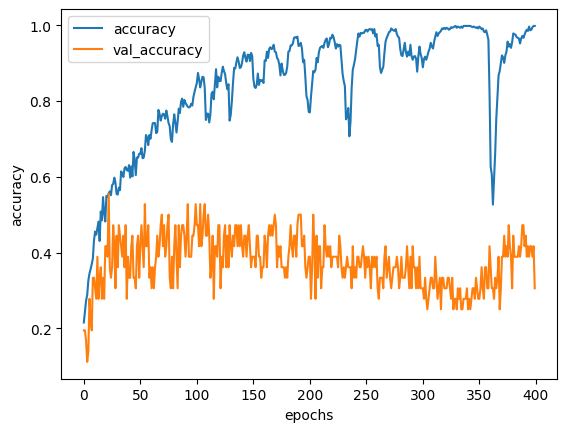

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

### 모델 평가
데이터 대부분이 분포되어 있는 클래스 0을 제외하고, 나머지 데이터를 가지고 평가

In [17]:
# 클래스가 1 이상에 해당하는 데이터만 t_target에 할당
# 해당 인덱스의 input 데이터도 t_input에 할당

t_target_index = pd.DataFrame(test_target)[test_target>=1].index
t_target = test_target[test_target>=1]
t_input = test_input.reset_index(drop=True)
t_input = t_input.loc[t_target_index]

model.evaluate(t_input, t_target)

1/1 [==============================] - 0s 49ms/step - loss: 10.6859 - accuracy: 0.3548


[10.68594741821289, 0.35483869910240173]

#### test 세트로 모델 predict 수행

In [18]:
a = model.predict(test_input)
[np.where(i == max(i))[0][0] for i in a][:10]

2/2 [==============================] - 0s 16ms/step


2023-04-05 14:12:32.454787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[2, 4, 2, 2, 2, 2, 2, 2, 3, 2]

In [19]:
list(test_target[:10])

[3, 3, 2, 2, 0, 1, 1, 3, 4, 2]

### 모델 저장

In [20]:
from keras.models import load_model
model.save('cls_model.h5')

---

## 2. movie_final_all 분석

### 스케일링
전국 스크린수와 총 관객수를 스케일링: RobustScaler() 사용

In [21]:
# 객체생성
robust_scaler = RobustScaler()

# *** '전국 스크린수'와 '총 관객수' 컬럼을 스케일링 ***
A_n = robust_scaler.fit_transform(movie_final_all['전국 스크린수'].values.reshape(-1,1))
movie_final_all.insert(0, '전국 스크린수_scaled', A_n)
movie_final_all.drop(['전국 스크린수'], axis=1, inplace=True)

A_n1 = robust_scaler.fit_transform(movie_final_all['총 관객수'].values.reshape(-1,1))
movie_final_all.insert(0, '총 관객수_scaled', A_n1)
movie_final_all.drop(['총 관객수'], axis=1, inplace=True)

# 변경이 잘 되었는지 확인
movie_final_all.columns

Index(['총 관객수_scaled', '전국 스크린수_scaled', 'Unnamed: 0', '순번', '영화명', '감독',
       '배급사', '개봉일', '영화형태', '국적', '전국 매출액', '전국 관객수', '서울 매출액', '서울 관객수',
       '장르', '등급', '영화구분', '연도', '월', '계절', '코로나', '출연', '평점', '감독_흥행',
       '배급사_흥행', '주연배우_흥행'],
      dtype='object')

### 라벨링
명목형 자료들을 라벨링: LabelEncoder() 사용

In [22]:
# input 데이터 라벨링

le_form = LabelEncoder()
le_nation = LabelEncoder()
le_genre = LabelEncoder()
le_rating = LabelEncoder()
le_class = LabelEncoder()
le_season = LabelEncoder()
le_year = LabelEncoder()

movie_labels = movie_final_all.copy()
movie_labels['영화형태'] = le_form.fit_transform(movie_final_all['영화형태'])
movie_labels['국적'] = le_nation.fit_transform(movie_final_all['국적'])
movie_labels['장르'] = le_genre.fit_transform(movie_final_all['장르'])
movie_labels['등급'] = le_rating.fit_transform(movie_final_all['등급'])
movie_labels['영화구분'] = le_class.fit_transform(movie_final_all['영화구분'])
movie_labels['계절'] = le_season.fit_transform(movie_final_all['계절'])
movie_labels['연도'] = le_year.fit_transform(movie_final_all['연도'])
movie_labels.drop(['Unnamed: 0'],axis=1,inplace=True)
movie_labels.columns

Index(['총 관객수_scaled', '전국 스크린수_scaled', '순번', '영화명', '감독', '배급사', '개봉일',
       '영화형태', '국적', '전국 매출액', '전국 관객수', '서울 매출액', '서울 관객수', '장르', '등급',
       '영화구분', '연도', '월', '계절', '코로나', '출연', '평점', '감독_흥행', '배급사_흥행',
       '주연배우_흥행'],
      dtype='object')

In [23]:
# target 데이터 라벨링
# 전국 관객수 기준, [50만미만/50만/100만/300만/500만/700만/1000만]으로 나누어 라벨링

movie_labels['분류클래스'] = np.where((movie_labels['전국 관객수'].values<500000), 0, 
                                 np.where((movie_labels['전국 관객수'].values>=500000) & (movie_labels['전국 관객수'].values<1000000), 1,
                                          np.where((movie_labels['전국 관객수'].values>=1000000) & (movie_labels['전국 관객수'].values<3000000), 2,
                                                   np.where((movie_labels['전국 관객수'].values>=3000000) & (movie_labels['전국 관객수'].values<5000000), 3,
                                                            np.where((movie_labels['전국 관객수'].values>=5000000) & (movie_labels['전국 관객수'].values<7000000), 4, 
                                                                    np.where((movie_labels['전국 관객수'].values>=7000000) & (movie_labels['전국 관객수'].values<10000000), 5, 6))))))
classes = sorted(movie_labels['분류클래스'].unique())
print(classes)
for i in classes:
    print(i, len(movie_labels[movie_labels['분류클래스']==i]))

[0, 1, 2, 3, 4, 5, 6]
0 2209
1 308
2 398
3 109
4 44
5 32
6 25


### 변수 정리
사용하는 컬럼만 독립변수와 종속변수에 할당

In [24]:
독립 = movie_labels[['장르', '등급', '감독_흥행','총 관객수_scaled',
               '배급사_흥행','주연배우_흥행','계절', '전국 스크린수_scaled','연도','코로나']].copy()

종속 = movie_labels[['분류클래스']].copy()

display(독립.info())
print()
display(종속.describe().round())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3125 entries, 0 to 3124
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   장르              3125 non-null   int64  
 1   등급              3125 non-null   int64  
 2   감독_흥행           3125 non-null   int64  
 3   총 관객수_scaled    3125 non-null   float64
 4   배급사_흥행          3125 non-null   int64  
 5   주연배우_흥행         3125 non-null   int64  
 6   계절              3125 non-null   int64  
 7   전국 스크린수_scaled  3125 non-null   float64
 8   연도              3125 non-null   int64  
 9   코로나             3125 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 244.3 KB


None

,분류클래스
count,3125.0
mean,1.0
std,1.0
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,6.0


### train, validation, test용 데이터 나누기

In [28]:
# 1. train 데이터(80%)와 test 데이터(20%)로 나누기
train_input, test_input, train_target, test_target = train_test_split(독립, 종속, test_size=0.05, random_state=1)
print(len(train_input), len(test_input))

2968 157


In [29]:
# 2. train 데이터를 train 데이터(80%*80%)와 val 데이터(80%*20%)로 나누기
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.10)
print(len(train_input), len(val_input), len(test_input))

2671 297 157


In [30]:
# 클래스 별로 고루 분배되었는지 확인
# 분배 잘 안되었으면 split 1, 2 다시 실행

classes = sorted(train_target['분류클래스'].unique())
for i in classes:
    print(i, len(train_target[train_target['분류클래스']==i]))
print()

for i in classes:
    print(i, len(val_target[val_target['분류클래스']==i]))
print()

for i in classes:
    print(i, len(test_target[test_target['분류클래스']==i]))

0 1886
1 270
2 344
3 89
4 37
5 25
6 20

0 213
1 24
2 37
3 13
4 4
5 5
6 1

0 110
1 14
2 17
3 7
4 3
5 2
6 4


In [31]:
# 확인 완료 되었으면 target 데이터 flatten
train_target, val_target, test_target = train_target.to_numpy().flatten(), \
val_target.to_numpy().flatten(), test_target.to_numpy().flatten()

### 딥러닝 모델 생성
#### (1) 하이퍼파라미터 튜닝

In [ ]:
# 모델 생성 함수
def create_model(learning_rate=0.01, num_layers=4, units=128):
    X = Input(shape=(train_input.shape[1],))
    H = Dense(units, activation = 'relu')(X)
    H = Dense(64, activation = 'relu')(H)
    H = Dense(32, activation = 'relu')(H)
    H = Dense(16, activation = 'relu')(H)
    Y = Dense(7, activation='softmax')(H)
    model = Model(X, Y)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Keras Classifier 생성
model = KerasClassifier(build_fn=create_model, epochs=200, batch_size=32, verbose=0)

# 하이퍼파라미터 탐색 범위
param_dist = {
    'learning_rate': np.arange(0.001, 0.01, 0.001),
    'num_layers': [2, 3, 4, 5],
    'units': [32, 64, 128, 256]
}

# 랜덤 서치 객체 생성
search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=3, n_iter=20, n_jobs=3, verbose=1)

# 랜덤 서치 수행
search_results = search.fit(train_input, train_target)

# 결과 출력
print('Best Score:', search_results.best_score_)
print('Best Params:', search_results.best_params_)

#### (2) 최적의 하이퍼파라미터 적용하여 모델 생성 

In [32]:
X = tf.keras.layers.Input(shape=[len(train_input.columns)])

H = tf.keras.layers.Dense(128, activation=tf.nn.relu)(X)
H = tf.keras.layers.Dense(64, activation=tf.nn.relu)(H)
H = tf.keras.layers.Dense(32, activation=tf.nn.relu)(H)

Y = tf.keras.layers.Dense(7, activation='softmax')(H)
model = tf.keras.models.Model(X,Y)

adam = tf.keras.optimizers.Adam(learning_rate=0.009)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

### 클래스별 가중치 적용하여 딥러닝 학습 실행
클래스별 편향된 분포를 조정하기 위해 클래스별 가중치를 계산한다.

In [33]:
# 레이블 클래스 빈도수 계산
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
classes=np.array([0, 1, 2, 3, 4, 5, 6]), y=train_target)

# 가중치 딕셔너리 생성
class_weight_dict = dict(enumerate(class_weights))

# 모델 학습 시 class_weight 파라미터에 가중치 딕셔너리 전달
history = model.fit(train_input, train_target, epochs=400, batch_size=32, 
class_weight=class_weight_dict, validation_data=(test_input, test_target))

Epoch 1/400


2023-04-05 14:14:38.461556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 2s 15ms/step - loss: 2.0371 - accuracy: 0.4897 - val_loss: 1.2575 - val_accuracy: 0.5159
Epoch 2/400
 8/84 [=>............................] - ETA: 0s - loss: 1.4225 - accuracy: 0.5391

2023-04-05 14:14:39.859015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 1s 8ms/step - loss: 1.6217 - accuracy: 0.5627 - val_loss: 1.9567 - val_accuracy: 0.4268
Epoch 3/400
84/84 [==============================] - 1s 7ms/step - loss: 1.6127 - accuracy: 0.5739 - val_loss: 0.7979 - val_accuracy: 0.6943
Epoch 4/400
84/84 [==============================] - 1s 7ms/step - loss: 1.6207 - accuracy: 0.6043 - val_loss: 1.4600 - val_accuracy: 0.4140
Epoch 5/400
84/84 [==============================] - 1s 7ms/step - loss: 1.5590 - accuracy: 0.6005 - val_loss: 0.7108 - val_accuracy: 0.7006
Epoch 6/400
84/84 [==============================] - 1s 7ms/step - loss: 1.4167 - accuracy: 0.6350 - val_loss: 0.7428 - val_accuracy: 0.7197
Epoch 7/400
84/84 [==============================] - 1s 7ms/step - loss: 1.3435 - accuracy: 0.6563 - val_loss: 0.6353 - val_accuracy: 0.7325
Epoch 8/400
84/84 [==============================] - 1s 7ms/step - loss: 1.3000 - accuracy: 0.6960 - val_loss: 0.6913 - val_accuracy: 0.7006
Epoch 9/400
84/84 [======

### epoch에 따른 accuracy 변화 그래프 확인

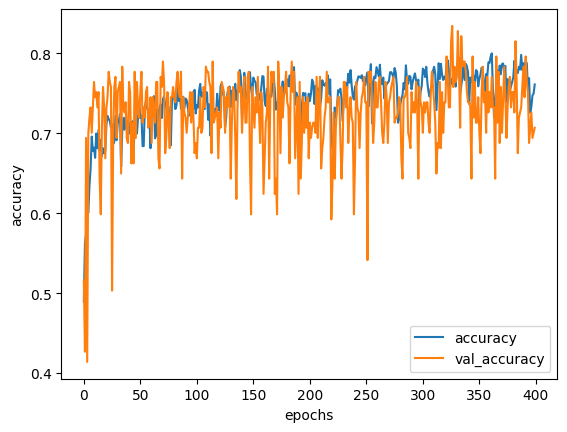

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

### 모델 평가
데이터 대부분이 분포되어 있는 클래스 0을 제외하고, 나머지 데이터를 가지고 평가

In [35]:
# 클래스가 1 이상에 해당하는 데이터만 t_target에 할당
# 해당 인덱스의 input 데이터도 t_input에 할당

t_target_index = pd.DataFrame(test_target)[test_target>=1].index
t_target = test_target[test_target>=1]
t_input = test_input.reset_index(drop=True)
t_input = t_input.loc[t_target_index]

model.evaluate(t_input, t_target)

2/2 [==============================] - 0s 48ms/step - loss: 2.0011 - accuracy: 0.3404


[2.0011141300201416, 0.3404255211353302]

#### test 세트로 모델 predict 수행

In [36]:
a = model.predict(test_input)
[np.where(i == max(i))[0][0] for i in a][:10]

5/5 [==============================] - 0s 7ms/step


2023-04-05 14:20:03.188880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0, 5, 0, 1, 3, 0, 0, 0, 2, 1]

In [37]:
list(test_target[:10])

[0, 3, 0, 2, 2, 0, 0, 0, 2, 2]

### 모델 저장

In [ ]:
from keras.models import load_model
model.save('cls_all_model.h5')